# A simple feed forward model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

## Load train and test sets

In [2]:
#Fake data: 100 samples with 5000 genes
X_cell_train = np.random.rand(100,5000)*100


In [11]:
y_cell_train = X_cell_train.mean(axis=1)+np.random.rand(100,)*10


In [13]:
X_cell_test = np.random.rand(10,5000)*100


In [14]:
y_cell_test = X_cell_test.mean(axis=1)+np.random.rand(10,)*10


# Train NN on cell line

In [27]:
# number of genes 
N = X_cell_train.shape[1]

model = K.Sequential([
    K.layers.Dropout(0.2, input_shape=(N,)),
    K.layers.Dense(1024, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001)),
    K.layers.Dropout(0.5),
    K.layers.Dense(128, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001)),
    K.layers.Dropout(0.5),
    K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_cell_train, y_cell_train, epochs=10, validation_data=(X_cell_test, y_cell_test))

Epoch 1/10
4/4 [==============================] - 1s 142ms/step - loss: 98184.5805 - root_mean_squared_error: 293.4280 - val_loss: 277408.7188 - val_root_mean_squared_error: 526.6942
Epoch 2/10
4/4 [==============================] - 0s 88ms/step - loss: 239720.5688 - root_mean_squared_error: 483.0560 - val_loss: 99200.1172 - val_root_mean_squared_error: 314.9575
Epoch 3/10
4/4 [==============================] - 0s 94ms/step - loss: 119866.4672 - root_mean_squared_error: 345.9465 - val_loss: 8073.8125 - val_root_mean_squared_error: 89.8437
Epoch 4/10
4/4 [==============================] - 0s 92ms/step - loss: 74563.3656 - root_mean_squared_error: 272.7413 - val_loss: 405.3260 - val_root_mean_squared_error: 20.0848
Epoch 5/10
4/4 [==============================] - 0s 83ms/step - loss: 21259.6574 - root_mean_squared_error: 145.6527 - val_loss: 4072.0552 - val_root_mean_squared_error: 63.7975
Epoch 6/10
4/4 [==============================] - 0s 82ms/step - loss: 20334.7238 - root_mean_squa

# Eval performance on cell line test set

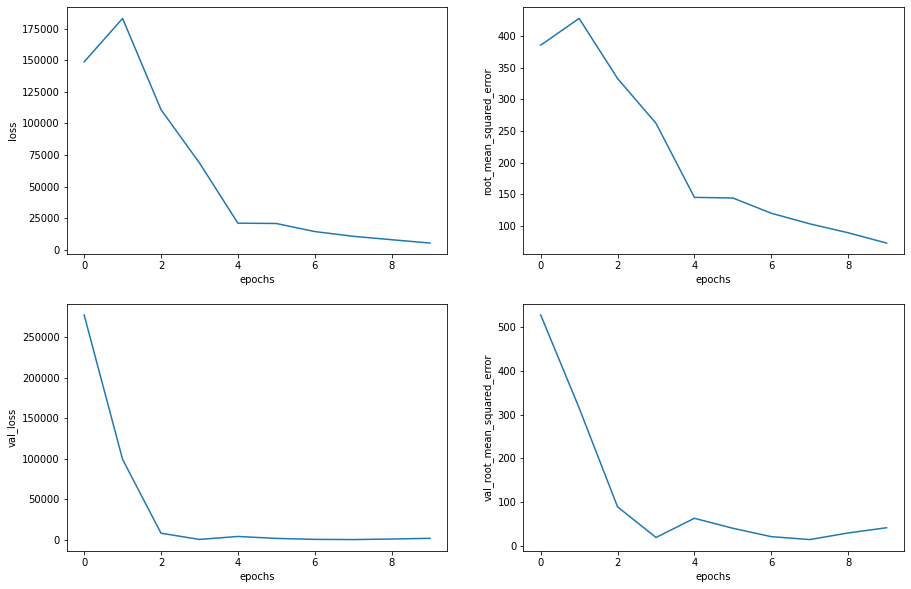

In [30]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
perf_dict = history.history
loss = perf_dict['loss']
accuracy = perf_dict['root_mean_squared_error']
val_loss = perf_dict['val_loss']
val_accuracy = perf_dict['val_root_mean_squared_error']
ax1.plot(loss)
ax2.plot(accuracy)
ax3.plot(val_loss)
ax4.plot(val_accuracy)
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
ax3.set_xlabel('epochs')
ax4.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_ylabel('root_mean_squared_error')
ax3.set_ylabel('val_loss')
ax4.set_ylabel('val_root_mean_squared_error')
plt.show()

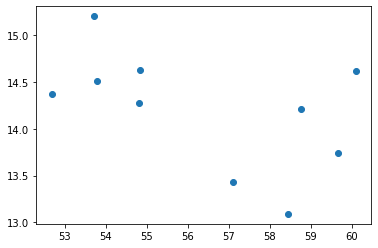

In [32]:
plt.scatter(y_cell_test,model.predict(X_cell_test))

# Fine tune on patient data
Pass patient data to network, extract feature values in last layer. Use the extracted feature to train a pfs regressor

In [33]:
model.get_layer(index=1)

# Save model

In [ ]:
model = K.models.load_model(model_dir)

In [ ]:
model_dir = os.path.join('6.871models', 'simpleNN042721')
shutil.rmtree(model_dir)
model.save(model_dir)
